# Predicting Network Anomalies

## Imports

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import random
import warnings
import ipywidgets as widgets
from IPython.display import display, clear_output

from dspot_src.peak_over_threshold.dspot import DriftStreamingPeakOverThreshold

## Data Cleaning

Our final supervised models require a labeled dataset, which we populate via unsupervised learning on NetMicroscope's historical database. In order to avoid training on non-sensical anomalies, we need to first filter this data for usable training data. Let's start with just loading the data. In order to create a feasible scope for our project, we limit ourselves to predicting latency anomalies.

In [2]:
all_data = pd.read_csv('netmicroscope_database.csv')

# Select the features we care about
features = all_data[['hostname', 'date', 'ping_jitter', 'ping_latency', 'ping_low', 'ping_high']]

Now that our features are selected, we want to account for the discontinuity in our data. NetMicroscope's historical dataset has a number of gaps in its data collection; trying to use data during periods of disparate data collection could be problematic. Also, I found that a number of NetMicroscope devices report the same metric (0 variation) for each measurement. This suggests that the data is not being accurately measured; so we remove those devices.

In [3]:
data = features.copy()

# Parse day of each row
data['date'] = pd.to_datetime(data['date'])
data['day'] = data['date'].dt.date

# Identify and exclude hosts where >50% of ping_latency values are the same
hosts_to_exclude = set()
for hostname, group in data.groupby('hostname'):
    latency_counts = group['ping_latency'].value_counts(normalize=True)
    if any(latency_counts > 0.98):
        hosts_to_exclude.add(hostname)
filtered_data = data[~data['hostname'].isin(hosts_to_exclude)]

# Define the periods of activity (in the visualization of the next cell, I manually
# identified which periods had consistent coverage)
periods = [
    ('2025-04-16', '2025-05-01'),
    ('2025-05-27', '2025-06-20'),
    ('2025-07-01', '2025-08-01')
]

# We will exclude devices that aren't sufficiently active for the periods above
all_devices = set(filtered_data['hostname'].unique())
devices_to_exclude = set()

# Iterate over those date periods and require 1 measurement for 75% of the days in the period
for start, end in periods:
    period_data = filtered_data[(filtered_data['date'] >= start) & (filtered_data['date'] <= end)]
    total_days = (pd.to_datetime(end) - pd.to_datetime(start)).days + 1
    device_days_active = period_data.groupby('hostname')['day'].nunique()
    threshold = total_days * 0.75
    devices_below_threshold = device_days_active[device_days_active < threshold].index
    devices_to_exclude.update(devices_below_threshold)
    # Manually exclude devices that weren't present at all for the period
    inactive_devices = all_devices - set(period_data['hostname'].unique())
    devices_to_exclude.update(inactive_devices)
filtered_data = filtered_data[~filtered_data['hostname'].isin(devices_to_exclude)]

# Return the data from those periods that were not excluded
final_filtered_data = pd.DataFrame()
for start, end in periods:
    period_data = filtered_data[(filtered_data['date'] >= start) & (filtered_data['date'] <= end)]
    final_filtered_data = pd.concat([final_filtered_data, period_data])

clean_data = final_filtered_data

In [4]:
def visualize_device_points(full_data: pd.DataFrame, subset_data: pd.DataFrame):
    # Convert the 'date' column to datetime in both DataFrames
    full_data = full_data.copy()
    subset_data = subset_data.copy()
    full_data["date"] = pd.to_datetime(full_data["date"])
    subset_data["date"] = pd.to_datetime(subset_data["date"])

    # Get all unique hostnames from both DataFrames
    all_hostnames = sorted(
        set(full_data["hostname"].unique()) | set(subset_data["hostname"].unique())
    )
    hostname_to_y = {hostname: i for i, hostname in enumerate(all_hostnames)}

    # Prepare data for visualization
    plot_data = []

    # Add all points from full_data
    for idx, row in full_data.iterrows():
        plot_data.append(
            dict(
                hostname=row["hostname"],
                date=row["date"],
                y=hostname_to_y[row["hostname"]],
                source="full",
            )
        )

    # Add all points from subset_data
    for idx, row in subset_data.iterrows():
        plot_data.append(
            dict(
                hostname=row["hostname"],
                date=row["date"],
                y=hostname_to_y[row["hostname"]],
                source="subset",
            )
        )

    # Convert to DataFrame
    plot_df = pd.DataFrame(plot_data)

    # Sort so subset points are plotted last (on top)
    plot_df = plot_df.sort_values("source", ascending=True)  # 'full' before 'subset'

    # Create the interactive plot, color by 'source'
    fig = px.scatter(
        plot_df,
        x="date",
        y="y",
        color="source",
        title="Device Records (Subset Highlighted)",
        labels={"y": "Device"},
        color_discrete_map={"full": "lightblue", "subset": "#F99"},
    )

    # Update marker size for better visibility
    fig.update_traces(marker=dict(size=8, opacity=0.7))

    # Customize layout for better zooming and large data handling
    fig.update_layout(
        xaxis=dict(rangeslider=dict(visible=True), title="Time"),
        yaxis=dict(title="Devices", showticklabels=False),
        height=800,
    )

    fig.show()
    
visualize_device_points(features, clean_data)

It's hard to catch this, but – if you zoom in far enough – you can see that there are sometimes two points collected for devices in short intervals. For example, points at 23 seconds past the minute are often followed by another at 33 seconds past the minute. Trying to learn anomaly patterns of these individual points is a more complex modeling task; therefore, we aggregate these points (averaging all metrics for one device) when collected within 10 minutes of each other. 

In [5]:
# Function to merge close points
def merge_close_points(df, time_col='date', group_col='hostname', time_window='10min'):
    merged = []
    for hostname, group in df.groupby(group_col):
        group = group.sort_values(time_col)
        current_group = [group.iloc[0]]
        for i in range(1, len(group)):
            prev = current_group[-1]
            curr = group.iloc[i]
            if (curr[time_col] - prev[time_col]) <= pd.Timedelta(time_window):
                current_group.append(curr)
            else:
                merged.append(pd.DataFrame(current_group).mean(numeric_only=True).to_dict())
                merged[-1][group_col] = prev[group_col]
                merged[-1][time_col] = pd.to_datetime(pd.DataFrame(current_group)[time_col]).mean()
                current_group = [curr]
        # Add the last group
        if current_group:
            merged.append(pd.DataFrame(current_group).mean(numeric_only=True).to_dict())
            merged[-1][group_col] = current_group[-1][group_col]
            merged[-1][time_col] = pd.to_datetime(pd.DataFrame(current_group)[time_col]).mean()
    return pd.DataFrame(merged)

clean_data = merge_close_points(clean_data)

## Unsupervised Labeling

We were originally planning to naively implement the EMA strategy that Chase used this summer. After experimentation, though, we found that a universal threshold can lead to excessive classifications for one model and insufficient classifications for others. We considered two solutions: (1) a new algorithm designed to account for drift in the underlying distribution, and (2) manually tuning the parameters. First, let's make a function to help visualize our data (doesn't yet include anomalies).

In [6]:
clean_data["predictions"] = False

In [7]:
def choose_random_hostname(clean_data: pd.DataFrame, hostname_col: str = "hostname") -> str:
    """
    Returns a random hostname from clean_data.
    """
    hostnames = clean_data[hostname_col].unique()
    if len(hostnames) == 0:
        raise ValueError("No hostnames found in clean_data.")
    return random.choice(hostnames)

def plot_host_latency(clean_data: pd.DataFrame, hostname: str, time_col: str = "date", latency_col: str = "ping_latency", hostname_col: str = "hostname", predictions_col: str = "predictions"):
    """
    Plots time vs. ping_latency for the specified hostname.
    Points where predictions_col is True are colored orange.
    """
    host_data = clean_data[clean_data[hostname_col] == hostname].copy()
    if host_data.empty:
        print(f"No data found for hostname: {hostname}")
        return
    host_data[time_col] = pd.to_datetime(host_data[time_col])
    # Set color: orange if predictions_col is True, else default
    color = host_data[predictions_col].map(lambda x: "Anomaly" if x else "Normal") if predictions_col in host_data else "Normal"
    fig = px.scatter(
        host_data,
        x=time_col,
        y=latency_col,
        color=color if isinstance(color, pd.Series) else None,
        title=f"Ping Latency for Host: {hostname}",
        labels={time_col: "Time", latency_col: "Ping Latency"},
        color_discrete_map={"orange": "orange", "lightblue": "lightblue"}
    )
    fig.show()

plot_host_latency(clean_data, choose_random_hostname(clean_data))

Now, let's create a basic anomaly detection schema using a static threshold of $\omega$ standard deviations above the mean.

In [8]:
THRESHOLD = 2


# Convert the 'date' column to datetime
# clean_data["date"] = pd.to_datetime(data["date"])


# Initialize a column for anomalies
clean_data["basic_ema_anomaly"] = False

# Iterate over each host
for hostname, group in clean_data.groupby("hostname"):
    # Sort the group by date
    group = group.sort_values(by="date")

    # Initialize EMA model
    ema = None
    mean = None
    std = None

    # Process each period sequentially
    for start, end in periods:
        period_data = group[(group["date"] >= start) & (group["date"] <= end)]

        if ema is None:
            # Train EMA model on the first period
            ema = period_data["ping_latency"].ewm(span=10, adjust=False).mean()
        else:
            # Update EMA model with the current period
            ema = period_data["ping_latency"].ewm(span=10, adjust=False).mean()

        # Update mean and std based on the EMA values
        mean = ema.mean()
        std = ema.std()

        # Label anomalies in the current period
        for index, row in period_data.iterrows():
            ema_value = row["ping_latency"]
            if ema_value > mean + THRESHOLD * std:
                clean_data.loc[index, "basic_ema_anomaly"] = True
            else:
                clean_data.loc[index, "basic_ema_anomaly"] = False

clean_data["predictions"] = clean_data["basic_ema_anomaly"]

#### You can rerun the cell below to see multiple examples!

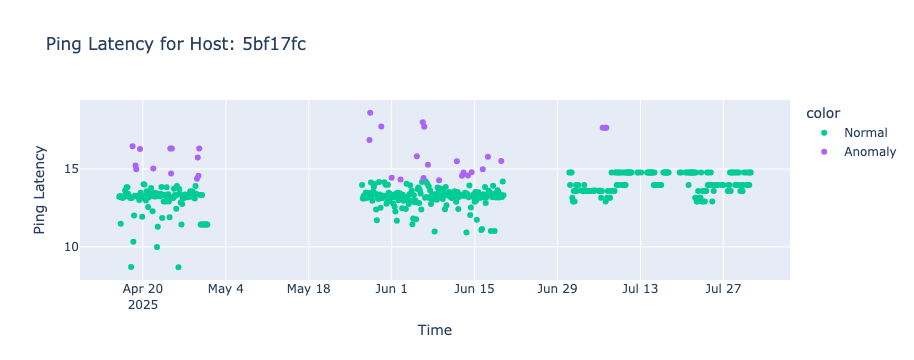

In [9]:
plot_host_latency(clean_data, choose_random_hostname(clean_data))

Flipping through some visualizations, it's clear that the model works in many instances; however, some devices with high variation have many points falsely classified as anomalies. This is also true when the first period is not representative of the other two periods. Therefore, I wanted to implement the (D)SPOT algorithm that is intended to change its thresholdhold over time.

In [24]:
def preprocess_for_spot(data, window_size=10):
    """
    Preprocess data to make it suitable for SPOT algorithm.

    Parameters:
    -----------
    data : array-like
        Original time series data
    method : str
        Preprocessing method:
        - 'absolute_deviation': |x - median| (recommended for your data)
        - 'squared_deviation': (x - median)^2
        - 'moving_range': |x[i] - x[i-1]|
        - 'zscore_magnitude': |z-score|
    window_size : int
        Window size for rolling statistics (if applicable)

    Returns:
    --------
    transformed_data : array
        Transformed data ready for SPOT (all non-negative, larger = more extreme)
    """

    warnings.filterwarnings("ignore") # the optimizer used in this library is verbose

    baseline = np.median(data)
    return np.abs(data - baseline)

# Initialize a column for DSPOT anomalies
clean_data["dspot_anomaly"] = False

# Iterate over each host
for hostname, group in clean_data.groupby("hostname"):
    # Sort the group by date
    group = group.sort_values(by="date")
    all_data = group["ping_latency"].values
    transformed_data = preprocess_for_spot(all_data)
    try:
        num_init = max(125, int(len(transformed_data) * 0.25))
        depth = 18
        z_spot = DriftStreamingPeakOverThreshold(
            data=transformed_data,
            num_candidates=18,
            risk=1.5e-2,
            num_init=num_init,
            depth=depth,
            epsilon=1e-8,
        )
        # Label anomalies based on SPOT thresholds
        mean = np.mean(all_data)
        for idx, (data_idx, row) in enumerate(group.iterrows()):
            value = transformed_data[idx]
            threshold = z_spot[idx]
            clean_data.loc[data_idx, "dspot_anomaly"] = (
                True if (value > threshold) & (all_data[idx] > mean) else False
            )
    except Exception as e:
        print("bad", e)
        for index in group.index:
            clean_data.loc[index, "dspot_anomaly"] = False

clean_data["predictions"] = clean_data["dspot_anomaly"]

bad arange: cannot compute length
bad zero-size array to reduction operation minimum which has no identity
bad arange: cannot compute length
bad zero-size array to reduction operation minimum which has no identity
bad zero-size array to reduction operation minimum which has no identity
bad zero-size array to reduction operation minimum which has no identity


#### You can rerun the cell below to see multiple examples!
Note that the meaning of the colors may change depending on the proportions (legend on the right is accurate)

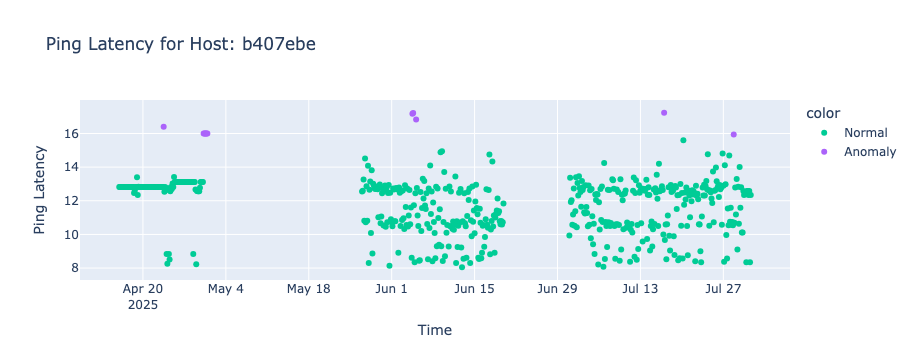

In [31]:
plot_host_latency(clean_data, choose_random_hostname(clean_data))

This model is excellent at parsing anomalous measurements from normal measurements for some models, but can struggle for other models– especially those with low variation. Similar to the EMA model, it includes a "risk" hyperparameter that controls how aggressively it classifies errors. So far, we tune this parameter for all models at once. However, we want to consider a third dataset where we manually control it for each. This has possible implications for a prediction mode, since there's a nondeterministic input (a human engineer) deciding the threshold for each device. I am curious whether our prediction models will be able to identify these patterns regardless, since when they are trained on one device only, the parameter is constant.

In [33]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# ============================================
# CONFIGURATION
# ============================================
INTERACTIVE = True  # Set to False to just review saved predictions

# ============================================
# Setup
# ============================================

if INTERACTIVE:
    # Initialize the tuned predictions column
    clean_data["tuned_dspot_anomaly"] = False
else:
    # Load previously saved predictions
    clean_data = pd.read_csv("clean_labeled.csv")
    clean_data["date"] = pd.to_datetime(clean_data["date"])
    # Use the saved predictions for visualization
    clean_data["predictions"] = clean_data.get("tuned_dspot_anomaly", False)

# Get list of all hostnames
all_hostnames = clean_data['hostname'].unique().tolist()
current_host_idx = 0

# Store current predictions temporarily
current_predictions = {}

def preprocess_for_spot_simple(data):
    """Simplified preprocessing for interactive tuning"""
    baseline = np.median(data)
    return (data - baseline) ** 2

def run_dspot_for_host(hostname, risk_value):
    """Run DSPOT for a specific host with given risk parameter"""
    group = clean_data[clean_data['hostname'] == hostname].sort_values(by='date')
    all_data = group['ping_latency'].values
    transformed_data = preprocess_for_spot_simple(all_data)
    
    try:
        num_init = max(125, int(len(all_data) * 0.25))
        z_spot = DriftStreamingPeakOverThreshold(
            data=transformed_data,
            num_candidates=18,
            risk=risk_value,
            num_init=num_init,
            depth=18,
            epsilon=1e-8,
        )
        
        mean = np.mean(all_data)
        for idx, data_idx in enumerate(group.index):
            value = transformed_data[idx]
            threshold = z_spot[idx]
            is_anomaly = (value > threshold) & (all_data[idx] > mean)
            clean_data.loc[data_idx, 'predictions'] = is_anomaly
            current_predictions[data_idx] = is_anomaly
    except:
        for data_idx in group.index:
            clean_data.loc[data_idx, 'predictions'] = False
            current_predictions[data_idx] = False

def update_plot(hostname, risk_value=None):
    """Update predictions and plot"""
    if INTERACTIVE and risk_value is not None:
        run_dspot_for_host(hostname, risk_value)
    with output:
        clear_output(wait=True)
        plot_host_latency(clean_data, hostname)

def on_risk_change(change):
    """Update plot when risk slider changes"""
    hostname = all_hostnames[current_host_idx]
    update_plot(hostname, change['new'])

def on_next_host(b):
    """Save current predictions and move to next host (or just navigate in review mode)"""
    global current_host_idx
    
    if INTERACTIVE:
        # Save predictions for current host
        hostname = all_hostnames[current_host_idx]
        group_indices = clean_data[clean_data['hostname'] == hostname].index
        for idx in group_indices:
            if idx in current_predictions:
                clean_data.loc[idx, 'tuned_dspot_anomaly'] = current_predictions[idx]
    
    # Move to next host
    current_host_idx += 1
    
    if current_host_idx >= len(all_hostnames):
        with output:
            clear_output(wait=True)
            if INTERACTIVE:
                print(f"✓ All {len(all_hostnames)} hosts tuned!")
                print(f"Total anomalies detected: {clean_data['tuned_dspot_anomaly'].sum()}")
            else:
                print(f"✓ Reviewed all {len(all_hostnames)} hosts!")
    else:
        hostname = all_hostnames[current_host_idx]
        progress_label.value = f"Host {current_host_idx + 1} of {len(all_hostnames)}: {hostname}"
        
        if INTERACTIVE:
            # Reset slider and show new host
            risk_slider.value = 1e-3
            update_plot(hostname, risk_slider.value)
        else:
            # Just show the next host with saved predictions
            update_plot(hostname)

# Create widgets
progress_label = widgets.Label(
    value=f"Host 1 of {len(all_hostnames)}: {all_hostnames[0]}",
    layout=widgets.Layout(width='500px')
)

if INTERACTIVE:
    risk_slider = widgets.FloatLogSlider(
        value=1e-3,
        base=10,
        min=-4,  # 1e-4
        max=-1,  # 1e-1
        step=0.1,
        description='Risk:',
        readout_format='.1e',
        style={'description_width': '60px'},
        layout=widgets.Layout(width='500px')
    )
    button_label = 'Save & Next Host'
else:
    button_label = 'Next Host'

next_button = widgets.Button(
    description=button_label,
    button_style='success',
    layout=widgets.Layout(width='200px', height='40px')
)

output = widgets.Output()

# Attach event handlers
if INTERACTIVE:
    risk_slider.observe(on_risk_change, names='value')
next_button.on_click(on_next_host)

# Display widgets - controls first, then plot
if INTERACTIVE:
    controls = widgets.VBox([
        progress_label,
        risk_slider,
        next_button
    ])
else:
    controls = widgets.VBox([
        widgets.Label(value="📊 Review Mode - Viewing saved predictions"),
        progress_label,
        next_button
    ])

display(controls)
display(output)

# Show initial plot
hostname = all_hostnames[current_host_idx]
if INTERACTIVE:
    update_plot(hostname, risk_slider.value)
else:
    update_plot(hostname)

Output()

In [34]:
clean_data.to_csv("clean_labeled.csv")

There are a number of models that aren't able to detect any anomalies. After reviewing the paper (which is quite dense), I believe this is due to relatively low variation in the initialization data for these models. Therefore, when analyzing the tuned (D)SPOT, we should only consider devices that have some anomalies detected. Otherwise, a models that always predicts "no anomaly will occur" would be 100% correct on that subset of the data.